In [182]:
import os
import sys
import rdflib
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON
from hdbscan import HDBSCAN

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [177]:
get_mid = lambda uri: uri.replace("http://rdf.freebase.com/ns", "")

def get_sequences(filename, sep=" ", min_len=1):
    for line in open(filename, "r"):
        sequence = line.split(sep)
        # tofix -> removing the \n at the end of the line
        sequence[-1] = sequence[-1][:-1]
        if len(sequence) >= min_len:
            yield sequence
            
def scatter_plot(two_dim_vecs, word_labels=None, colors="#00897B", user="chrispolo", api_key="89nned6csl"):
    py.sign_in(user, api_key)

    x_coord = two_dim_vecs[:, 0]
    y_coord = two_dim_vecs[:, 1]

    trace = go.Scattergl(
        x = x_coord, #
        y = y_coord, #
        mode = 'markers',
        text = word_labels, #
        marker = dict(
            color = colors,
            line = dict(width = 1)
        )
    )

    data = [trace]
    return data

def get_types(resource, graph):
    prep_query = sparql.prepareQuery("""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        SELECT ?type
        WHERE { 
          ?resource rdf:type ?type .
        }
    """)
    resource = rdflib.URIRef(resource)
    return graph.query(prep_query, initBindings={'resource': resource})

def get_color(n):
    #         1.orange,  2.fuchsia, 3.yellow,  4.lgt-blue, 5.green,  6.blue,    7.white,   8.violet
    colors = ["#FF8F00", "#F50057", "#FFFF00", "#00E5FF", "#76FF03", "#2979FF", "#FFFFFF", "#9C27B0"]
    color = ""
    if n < 0:
        color = "#009688" # noise
    elif n < len(colors):
        color = colors[n]
    else:
        color = "#" + format(n**5, '06X')
    return color

In [3]:
%%time
dbpedia_type_graph = rdflib.Graph()
dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 17min 38s, sys: 1min 15s, total: 18min 54s
Wall time: 19min 58s


In [4]:
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

### Training the Model

In [5]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [6]:
%%time
mid2types = dict()
for uri in model.vocab:
    mid = uri.replace("http://rdf.freebase.com/ns", "")
    if mid in mid2dbpedia:
        dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
        mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
        if len(mid_types) > 0:
            mid2types[mid] = mid_types

CPU times: user 16min 11s, sys: 35.4 s, total: 16min 46s
Wall time: 16min 56s


### Dimensionality reduction of embeddings

In [7]:
%%time
mid_prefix = "http://rdf.freebase.com/ns"

embeddings = [model[uri] for uri in model.vocab]
uris = [uri for uri in model.vocab]
# colors = [ "#00897B" if uri.startswith(mid_prefix) else "#FFEB3B" for uri in model.vocab]

tsne = TSNE(n_components=2)
twodim_embeddings = tsne.fit_transform(embeddings)

CPU times: user 6min 13s, sys: 1min 36s, total: 7min 50s
Wall time: 6min 27s


In [19]:
colors = ["#FFEB3B" if "<http://dbpedia.org/ontology/Agent>" in mid2types.get(get_mid(uri), []) else "#00897B" for uri in model.vocab]

In [18]:
# mids   = []
# labels = []
# for mid in mid2types:
#     if 

In [17]:
# hand = "http://rdf.freebase.com/ns/m/01dyvs"
# palm = "http://rdf.freebase.com/ns/m/0479b"
# foot = "http://rdf.freebase.com/ns/m/0f4_l"

# model.most_similar(positive=[hand, palm], negative=[foot], topn=15)
# model.most_similar("http://rdf.freebase.com/ns/m/01dyvs", topn=15)

### Plot

In [20]:
scatter_data = scatter_plot(twodim_embeddings, uris, colors=colors)
py.iplot(scatter_data, filename='Data')

Check it [here](https://plot.ly/create/?fid=chrispolo:1238)

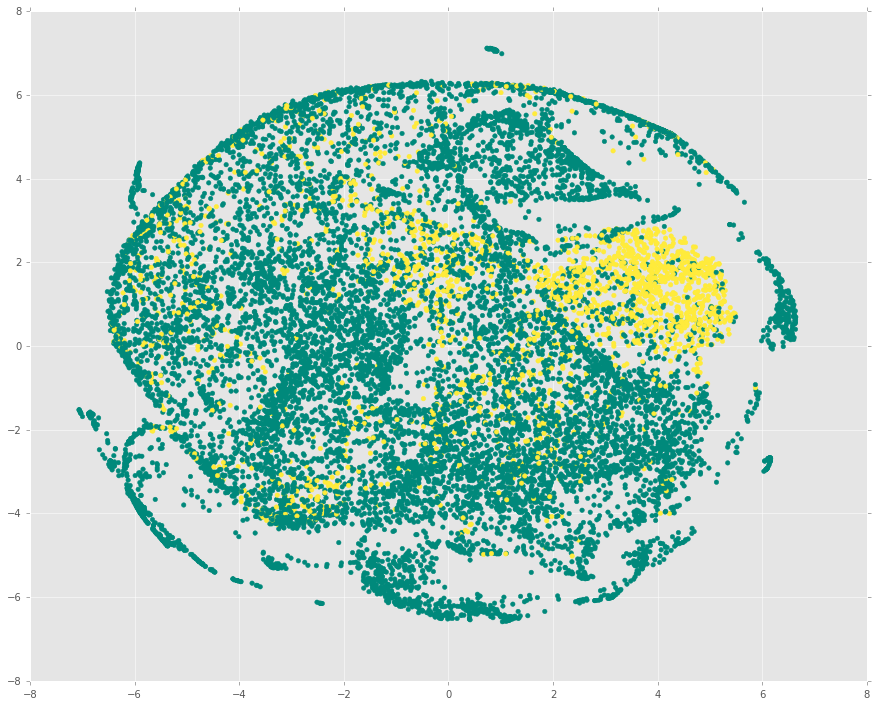

In [13]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodim_embeddings]
y = [point[1] for point in twodim_embeddings]
plt.scatter(x, y, color=colors)
plt.show()

In [29]:
"<http://dbpedia.org/ontology/Agenat>" in mid2types["/m/016kft"]

False

In [155]:
def is_person(uri):
    result = False
    mid = get_mid(uri)
    types = mid2types[mid]
    if  "<http://dbpedia.org/ontology/Person>" in types and \
        "<http://dbpedia.org/ontology/Place>" not in types and \
        "<http://dbpedia.org/ontology/Event>" not in types:
        result = True
    return result

def is_place(uri):
    result = False
    mid = get_mid(uri)
    types = mid2types[mid]
    if  "<http://dbpedia.org/ontology/Place>" in types and \
        "<http://dbpedia.org/ontology/Agent>" not in types and \
        "<http://dbpedia.org/ontology/Event>" not in types:
        result = True
    return result

def is_work(uri):
    result = False
    mid = get_mid(uri)
    types = mid2types[mid]
    if  "<http://dbpedia.org/ontology/Work>" in types and \
        "<http://dbpedia.org/ontology/Agent>" not in types and \
        "<http://dbpedia.org/ontology/Event>" not in types:
        result = True
    return result

def is_species(uri):
    result = False
    mid = get_mid(uri)
    types = mid2types[mid]
    if  "<http://dbpedia.org/ontology/Species>" in types and \
        "<http://dbpedia.org/ontology/Agent>" not in types and \
        "<http://dbpedia.org/ontology/Event>" not in types:
        result = True
    return result

def is_event(uri):
    result = False
    mid = get_mid(uri)
    types = mid2types[mid]
    if  "<http://dbpedia.org/ontology/Event>" in types and \
        "<http://dbpedia.org/ontology/Agent>" not in types and \
        "<http://dbpedia.org/ontology/Work>" not in types:
        result = True
    return result

def get_ground_truth(mids):
    gt = []
    for mid in mids:
        t = 0
        if is_person(mid):  t = 1
        if is_place(mid):   t = 2
        if is_work(mid):    t = 3
        if is_species(mid): t = 4
        if is_event(mid):   t = 5
        gt += [t]
    return np.asarray(gt)

In [76]:
embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types])
mids   = np.asarray([mid for mid in mid2types])
labels = np.asarray([1 if is_person(mid) else 0 for mid in mid2types])

random_idx = np.random.choice(range(len(embeds)), len(embeds), replace=False)
split_point = len(embeds) * 70 / 100
training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
mids_train,   mids_test   = mids[training_idx], mids[test_idx]
labels_train, labels_test = labels[training_idx], labels[test_idx]

ground_truth = get_ground_truth(mids)

In [152]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=15)
classifier.fit(embeds_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

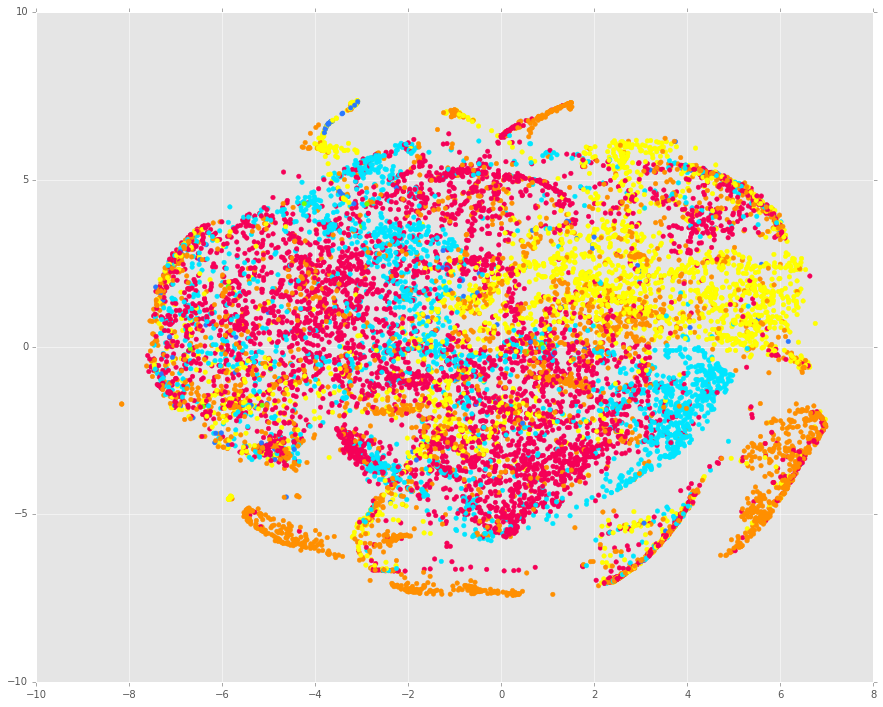

In [181]:
twodims = tsne.fit_transform(embeds)
colors  = [get_color(i) for i in ground_truth]

fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

In [153]:
c = 0
for i in range(len(embeds_test)):
    if classifier.predict([embeds_test[i]]) == [labels_test[i]]:
        c += 1
        
print len(embeds_test), c

3679 3056


In [237]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

# clusterer = HDBSCAN(min_cluster_size=30)
# clusterer = DBSCAN(eps=0.4, min_samples=5)
# clusterer = KMeans(n_clusters=7)
clusterer = SpectralClustering(n_clusters=7, eigen_solver='arpack', affinity="nearest_neighbors")
# clusterer = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=7)
clusterer_labels = clusterer.fit_predict(embeds.astype(np.double))

cluster_colors = [get_color(clust) for clust in clusterer_labels]

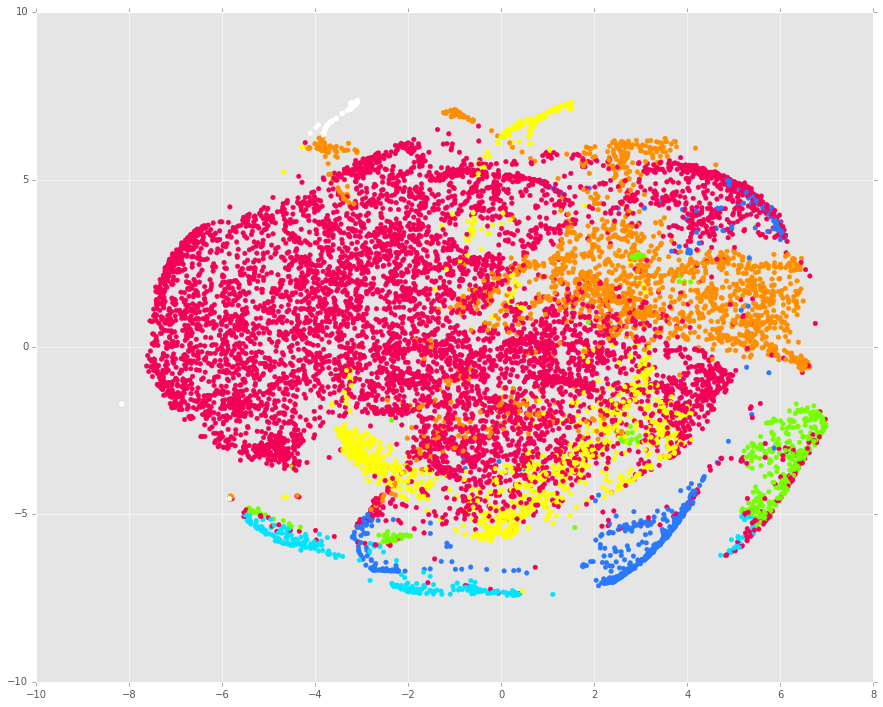

In [238]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=cluster_colors)
plt.show()